Import library yang dibutuhkan

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Upload file data yang akan digunakan  

In [2]:
# from google.colab import files 
# upload = files.upload()

Menampilkan data pada file data_nlp.csv menggunakan library pandas

In [4]:
#baca data
data = pd.read_csv('data_nlp.csv')

# Keeping only the neccessary columns
data = data[['ID','kategori','isi_laporan','sentimen']]
data

,ID,kategori,isi_laporan,sentimen
0,1,Fisik,Ibu saya sering pingsan dipukuli oleh ayah sam...,High
1,2,Psikis,"Sejak kecil, ayah saya tidak menyukai penampil...",High
2,3,Seksual,Pagi tadi saya iseng mengunggah sebuah foto se...,High
3,4,Seksual,ANAK SAYA DIGERAYANGI OLEH LAKI-LAKI TIDAK DIK...,High
4,5,Fisik,Ada kasus pencabulan di SLB dekat rumah. Belum...,High
...,...,...,...,...
495,496,Seksual,"Saya benci dengan kakak ipar saya, dia suka me...",High
496,497,penelantaran,Ayah saya pergi dan tidak pernah kembali karen...,High
497,498,Fisik,"Kenalan saya mengadopsi anak, tapi karena anak...",High
498,499,Seksual,Kemarin saya bertemu lagi dengan teman SMA yan...,High


Memeriksa data yang kosong 

In [5]:
data.isnull().sum()

ID             0
kategori       0
isi_laporan    0
sentimen       0
dtype: int64

Formatting data pada kolom isi laporan menggunakan regular expression

In [6]:
data = data[data.sentimen != "Medium"]

data['isi_laporan'] = data['isi_laporan'].apply(lambda x: x.lower())
data['isi_laporan'] = data['isi_laporan'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

data.head()

,ID,kategori,isi_laporan,sentimen
0,1,Fisik,ibu saya sering pingsan dipukuli oleh ayah sam...,High
1,2,Psikis,sejak kecil ayah saya tidak menyukai penampila...,High
2,3,Seksual,pagi tadi saya iseng mengunggah sebuah foto se...,High
3,4,Seksual,anak saya digerayangi oleh lakilaki tidak dike...,High
4,5,Fisik,ada kasus pencabulan di slb dekat rumah belum ...,High


Menampilkan jumlah data dengan kategori high dan low

In [7]:
#Checking total data
print(len(data[data.sentimen == "High"]))
print(len(data[data.sentimen == "Low"]))

333
167


Memisahkan teks menjadi potongan-potongan berupa token bisa berupa potongan huruf, kata, atau kalimat sebelum dianalisis lebih lanjut

In [8]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['isi_laporan'].values)
X = tokenizer.texts_to_sequences(data['isi_laporan'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentimen']).values

Membagi data kedalam data train sebesar 80% dan data test sebesar 20%

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(400, 53) (400, 2)
(100, 53) (100, 2)


Menghilangkan kolom yang tidak digunakan

In [10]:
data = data.drop(columns=['ID', 'kategori'])
data

,isi_laporan,sentimen
0,ibu saya sering pingsan dipukuli oleh ayah sam...,High
1,sejak kecil ayah saya tidak menyukai penampila...,High
2,pagi tadi saya iseng mengunggah sebuah foto se...,High
3,anak saya digerayangi oleh lakilaki tidak dike...,High
4,ada kasus pencabulan di slb dekat rumah belum ...,High
...,...,...
495,saya benci dengan kakak ipar saya dia suka men...,High
496,ayah saya pergi dan tidak pernah kembali karen...,High
497,kenalan saya mengadopsi anak tapi karena anak ...,High
498,kemarin saya bertemu lagi dengan teman sma yan...,High


Mengubah data pada y_train dan y_test menjadi kategorikal

In [11]:
y_train = to_categorical(Y_train, 2)
y_test = to_categorical(Y_test, 2)

Membuat model machine learning mengunakan LSTM dan SpatialDropout1D (memiliki fungsi sama seperti dropout)

In [12]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D (0.5))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(2,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 128)           384000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 53, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 639,194
Trainable params: 639,194
Non-trainable params: 0
_________________________________________________________________
None


Menggunakan callback untuk menghentikan process train ketika accuracy sudah mencapai lebih dari 90%

In [24]:
#Implementasi Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

Melakukan proses training pada data menggunakan model yang telah dibuat

In [14]:
batch_size = 32
history = model.fit(X_train, Y_train, 
                    epochs = 15, 
                    batch_size=batch_size, 
                    validation_data=(X_test, Y_test),
                    verbose = 1,
                    callbacks=[callbacks])

Epoch 1/15
13/13 [==============================] - 29s 387ms/step - loss: 0.6826 - accuracy: 0.6010 - val_loss: 0.6352 - val_accuracy: 0.7100
Epoch 2/15
13/13 [==============================] - 4s 284ms/step - loss: 0.6570 - accuracy: 0.6412 - val_loss: 0.6118 - val_accuracy: 0.7100
Epoch 3/15
13/13 [==============================] - 4s 294ms/step - loss: 0.6376 - accuracy: 0.6306 - val_loss: 0.5956 - val_accuracy: 0.7100
Epoch 4/15
13/13 [==============================] - 4s 347ms/step - loss: 0.5726 - accuracy: 0.6770 - val_loss: 0.5836 - val_accuracy: 0.7300
Epoch 5/15
13/13 [==============================] - 5s 353ms/step - loss: 0.5162 - accuracy: 0.7399 - val_loss: 0.6343 - val_accuracy: 0.6500
Epoch 6/15
13/13 [==============================] - 4s 283ms/step - loss: 0.3863 - accuracy: 0.8504 - val_loss: 0.4701 - val_accuracy: 0.8200
Epoch 7/15
13/13 [==============================] - 4s 283ms/step - loss: 0.2467 - accuracy: 0.9213 - val_loss: 0.6457 - val_accuracy: 0.8200

Akur

Melihat nilai loss dan accuracy pada data yang telah di train

In [15]:
score = model.evaluate(X_test, Y_test, verbose=False)
print("loss = ",score[0])
print("accuracy = ",score[1])

loss =  0.6457306146621704
accuracy =  0.8199999928474426


Menampilkan visualisasi nilai akurasi

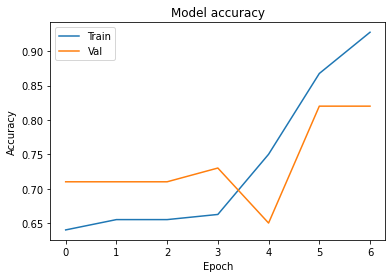

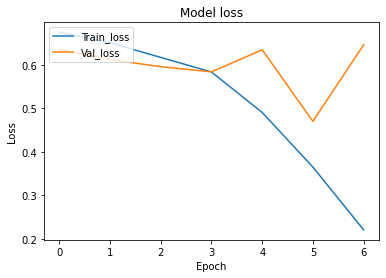

In [19]:
#melakukan plot untuk model accuracy pada training data 
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Val_loss'], loc='upper left')
plt.show()

Melakukan tes prediksi menggunakan model yang telah dibuat dan data yang telah di train untuk memeriksa apakah hasil laporan masuk kategori high atau low

In [20]:
def printpred(sample):
  
  sample = tokenizer.texts_to_sequences(sample)
  sample = pad_sequences(sample, maxlen=53, dtype='int32', value=0)
  sentimen = model.predict(sample,batch_size=1,verbose = 2)[0]
  
  if(np.argmax(sentimen) == 0):
    print("Low\n")
  elif (np.argmax(sentimen) == 1):
    print("High\n")

In [22]:
#Prediksi Hasil Model
sample1 = ["Suami sangat kasar dan sering melakukan KDRT terhadap saya"]
sample2 = ["Saya menemukan bayi di kolong jembatan. Sepertinya baru dibuang tadi malam"]

print("".join(sample1))
printpred(sample1)

print("".join(sample2))
printpred(sample2)

Suami sangat kasar dan sering melakukan KDRT terhadap saya
1/1 - 0s
High

Saya menemukan bayi di kolong jembatan. Sepertinya baru dibuang tadi malam
1/1 - 0s
Low



Melakukan konversi data isi laporan yang telah di tokenize untuk di export menjadi sample_data


In [ ]:
import json
json.dumps(tokenizer.word_index)

In [ ]:
pip install tensorflowjs

Melakukan export model menggunakan tensorflow.js

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')